In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline

# Physics-Informed Neural Networks (Part 1)

This notebook will guide you towards the implementation of a Physics-Informed Neural Network (PINN), which you can ultimately use to solve physics ODEs and PDEs as optimization problems. We will later see that the true strength of the PINN approach is not to simply solve "forward" ODE/PDE problems (initial value and boundary value problems), but to solve "inverse" problems that are constrained by physics ODEs/PDEs.

Before implementing a fully fledged PINN, we will implement several key algorithms/routines that form the building blocks of PINNs. In this notebook, you will do the following:

1. Implement the gradient descent algorithm

    1.1. Compute gradients of the function you want to optimize using analytical gradient calculations
    
    1.2. Compute gradients using automatic differentiation
    
    
2. Solve an ODE as an optimization problem, using a polynomial trial function (instead of a neural network) and using gradient descent (with automatic differentiation) to solve the optimization.

## 1. Gradient descent algorithm
### 1.1. Gradient descent using analytical gradients

We'll start by implementing the gradient descent algorithm.

Consider the bi-variate function $f(x,y) = 3(x-1)^2 + (y-2)^2$, which has a (global) minimum at $(x,y) = (1,2)$. Here you will use the gradient descent method to find the minimum.

1) Define the function "f(x,y)" in Python. Some 2D plotting code is provided for you to visualize the function in the 2D (x,y plane).


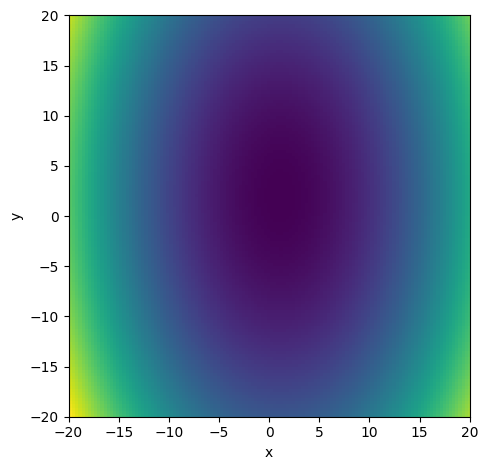

In [2]:
def f(x,y):
    return 3 * (x - 1)**2 + (y - 2)**2

# This code generates a 2D grid of X and Y values so that you can evaluate the function f(X,Y) on the 2D x-y plane.
X = np.linspace(-20,20,128)
Y = np.linspace(-20,20,128)
X, Y = np.meshgrid(X,Y)

plt.imshow(f(X,Y), origin='lower', extent = [X.min(),X.max(),Y.min(),Y.max()])
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

2) To implement gradient descent, you will need to calculate the gradient of $f(x,y)$ at any point $(x,y)$. Calculate the gradient of f(x,y) analytically and implement it in a funcation called "analytical_grad_f(x,y)". This function should return a 2-dimensional vector with entries $\partial_x f$ and $\partial_y f$.

In [3]:
def analytical_grad_f(x,y):
    dfdx = 6*(x-1)
    dfdy = 2*(y-2)
    return np.array([dfdx, dfdy])

3) Implement a routine that executes one gradient descent step: $\mathbf{X}^{n+1} (\equiv (x,y)^{n+1}) =  \mathbf{X}^{n} - lr \nabla f$, where $lr$ is the learning rate (which controls the gradient descent step size).

In [4]:
lr = 0.1 #learning rate parameter 

def gradient_descent_step(x, y):
    grad = analytical_grad_f(x, y)

    #Update
    x = x - lr*grad[0]
    y = y - lr*grad[1]
    return np.array([x, y])

4) Perform gradient descent starting with an initial guess of $(x,y)^{0} = (5,7)$. Set the learning rate $lr = 0.1$. Plot the trajectory of the gradient descent steps in the $(x,y)$ plane, overlayed on a colorplot of $f(x,y)$ (you can use a scatter plot for the gradient descent steps to illustrate the discrete points). Plot the $f(x,y)$ along the gradient descent trajectory to verify that you are converging to a minimum. These two plots should be presented side by side.

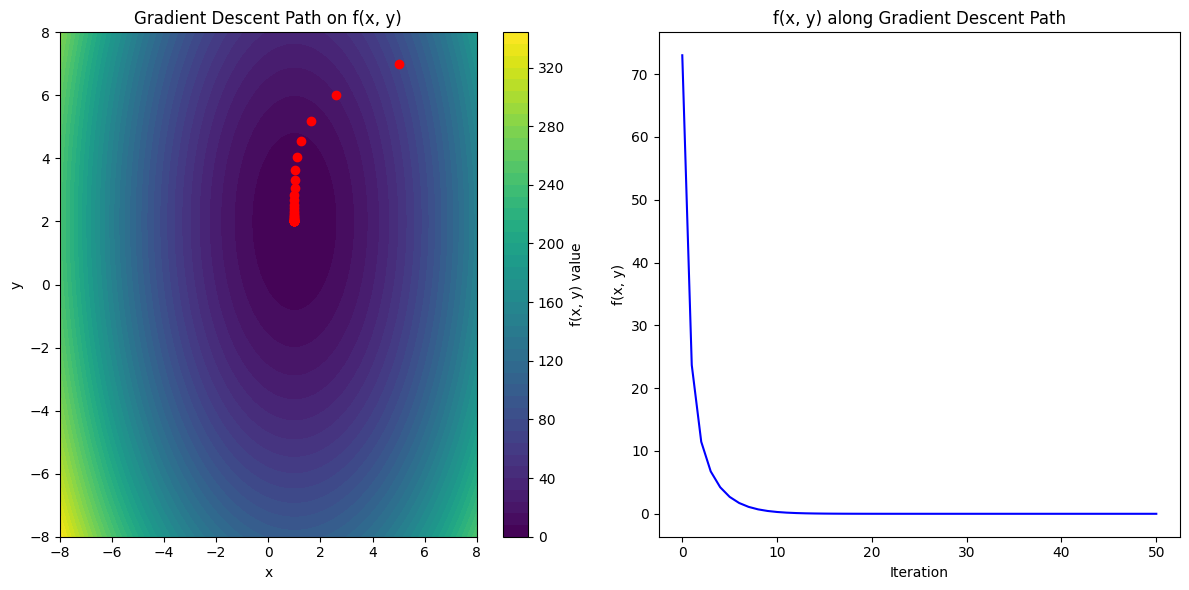

Last few steps in x_path: [1.0, 1.0, 1.0, 1.0, 1.0]
Last few steps in y_path: [2.0001742245718637, 2.000139379657491, 2.000111503725993, 2.0000892029807944, 2.0000713623846353]


In [5]:
# Manually calculate the gradient
def analytical_grad_f(x,y):
    dfdx = 6*(x-1)
    dfdy = 2*(y-2)
    return np.array([dfdx, dfdy])

#Initial guess
guess = (5, 7)

#Tunable parameters
lr = 0.1
steps = 50

#Arrays to trace/store grad descent steps
x_path = [guess[0]]
y_path = [guess[1]]
f_path = [f(guess[0], guess[1])]

# Define the gradient step
def gradient_descent_step(x, y):
    grad = analytical_grad_f(x, y)

    #Update
    x = x - lr*grad[0]
    y = y - lr*grad[1]
    return np.array([x, y])

# Loop gradient step (gradient descent)
x, y = guess
for _ in range(steps):
    x, y = gradient_descent_step(x, y)
    x_path.append(x)
    y_path.append(y)
    f_path.append(f(x,y))

# 2D grid of X and Y values
X = np.linspace(-8,8,128)
Y = np.linspace(-8,8,128)
X, Y = np.meshgrid(X,Y)
Z = f(X, Y)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Color plot of f(x, y)
cp = axes[0].contourf(X, Y, Z, levels=50, cmap='viridis')
axes[0].scatter(x_path, y_path, color='red')  # Gradient descent path
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Gradient Descent Path on f(x, y)')

# Line plot of f(x, y) along the gradient descent path
axes[1].plot(f_path, color='blue')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('f(x, y)')
axes[1].set_title('f(x, y) along Gradient Descent Path')

plt.colorbar(cp, ax=axes[0], label='f(x, y) value')
plt.tight_layout()
plt.show()

# Print the last few steps to check for convergence
print("Last few steps in x_path:", x_path[-5:])
print("Last few steps in y_path:", y_path[-5:])

<div style="background-color: #2a2c2b; color: white; padding: 10px; font-size: 14px;">

Plot left enablles us to visualize the path that gradient descent takes to approach the minimum of the function. Plot right tracks the value of f(x,y) as we preform gradient descent and we observe that the value of f(x,y) appears to decrease then bottom out at some minimum. 

Printing the last 5 values of x, and y we indeed see that they are converging towards the minimum (1, 2).
    
</div>

5) Repeat the above exercise with a different learning rate. $lr = 0.5$ and $lr = 1.1$. Comment on the convergence of the method for these learning rates.

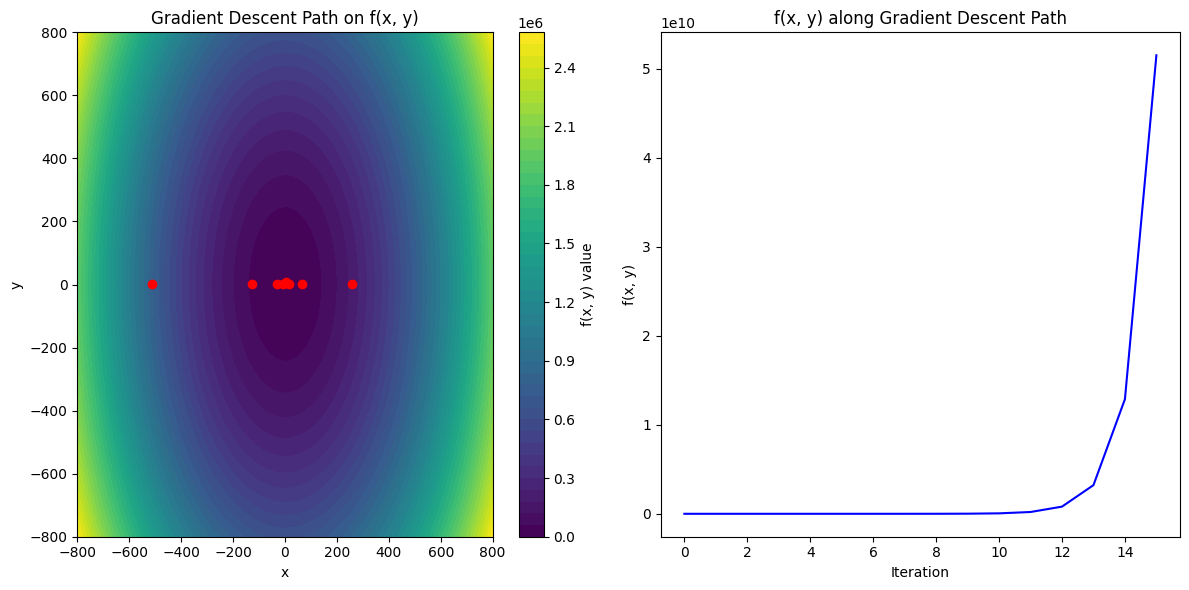

Last few steps in x_path: [-8191.0, 16385.0, -32767.0, 65537.0, -131071.0]
Last few steps in y_path: [2.0, 2.0, 2.0, 2.0, 2.0]


In [6]:
#Initial guess
guess = (5, 7)

#Tunable parameters
lr = 0.5
steps = 15

#Arrays to trace/store grad descent steps
x_path = [guess[0]]
y_path = [guess[1]]
f_path = [f(guess[0], guess[1])]

# Grad descent loop
x, y = guess
for _ in range(steps):
    x, y = gradient_descent_step(x, y)
    x_path.append(x)
    y_path.append(y)
    f_path.append(f(x,y))

# Define the plot range
scale_size = 100
x_min, x_max, y_min, y_max = -8*scale_size, 8*scale_size, -8*scale_size, 8*scale_size

# Filter out steps outside the range
filtered_x_path = [x for x in x_path if x_min <= x <= x_max]
filtered_y_path = [y for i, y in enumerate(y_path) if x_min <= x_path[i] <= x_max]

# Create the 2D grid for the contour plot within the defined range
X = np.linspace(x_min, x_max, 128)
Y = np.linspace(y_min, y_max, 128)
X, Y = np.meshgrid(X, Y)
Z = f(X, Y)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Color plot of f(x, y)
cp = axes[0].contourf(X, Y, Z, levels=50, cmap='viridis')
axes[0].scatter(filtered_x_path, filtered_y_path, color='red')  # Gradient descent path
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Gradient Descent Path on f(x, y)')

# Line plot of f(x, y) along the gradient descent path
axes[1].plot(f_path, color='blue')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('f(x, y)')
axes[1].set_title('f(x, y) along Gradient Descent Path')

plt.colorbar(cp, ax=axes[0], label='f(x, y) value')
plt.tight_layout()
plt.show()

# Print the last few steps to check for divergence
print("Last few steps in x_path:", x_path[-5:])
print("Last few steps in y_path:", y_path[-5:])

<div style="background-color: #2a2c2b; color: white; padding: 10px; font-size: 14px;">

Now the learning rate is too large. For this particular function, we find the target value of y but repeatedly overshoot in x. At each step, we travel past the value of x that results in the minimum and drift further and further from the point (1, 2).
    
</div>

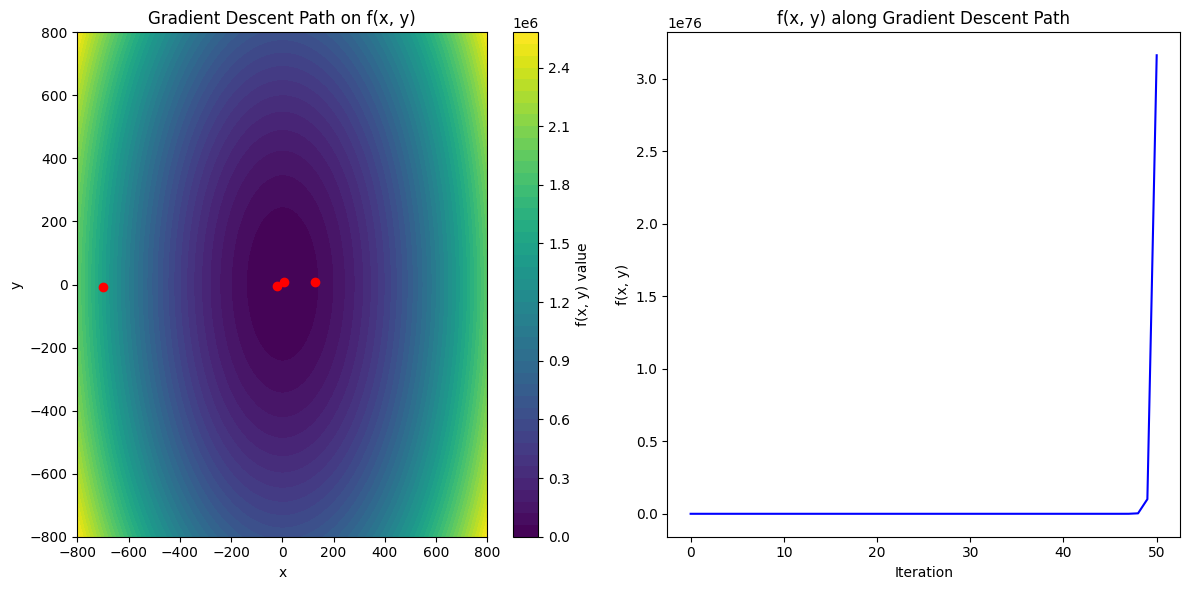

Last few steps in x_path: [1.0440209981399583e+35, -5.846517589583767e+35, 3.2740498501669103e+36, -1.83346791609347e+37, 1.0267420330123433e+38]
Last few steps in y_path: [21945.571928053163, -26330.286313663797, 31600.743576396562, -37916.49229167588, 45504.19075001107]


In [7]:
#Initial guess
guess = (5, 7)

#Tunable parameters
lr = 1.1
steps = 50

#Arrays to trace/store grad descent steps
x_path = [guess[0]]
y_path = [guess[1]]
f_path = [f(guess[0], guess[1])]

# Grad descent loop
x, y = guess
for _ in range(steps):
    x, y = gradient_descent_step(x, y)
    x_path.append(x)
    y_path.append(y)
    f_path.append(f(x,y))

# Define the plot range
scale_size = 100
x_min, x_max, y_min, y_max = -8*scale_size, 8*scale_size, -8*scale_size, 8*scale_size

# Filter out steps outside the range
filtered_x_path = [x for x in x_path if x_min <= x <= x_max]
filtered_y_path = [y for i, y in enumerate(y_path) if x_min <= x_path[i] <= x_max]

# Create the 2D grid for the contour plot within the defined range
X = np.linspace(x_min, x_max, 128)
Y = np.linspace(y_min, y_max, 128)
X, Y = np.meshgrid(X, Y)
Z = f(X, Y)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Color plot of f(x, y)
cp = axes[0].contourf(X, Y, Z, levels=50, cmap='viridis')
axes[0].scatter(filtered_x_path, filtered_y_path, color='red')  # Gradient descent path
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Gradient Descent Path on f(x, y)')

# Line plot of f(x, y) along the gradient descent path
axes[1].plot(f_path, color='blue')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('f(x, y)')
axes[1].set_title('f(x, y) along Gradient Descent Path')

plt.colorbar(cp, ax=axes[0], label='f(x, y) value')
plt.tight_layout()
plt.show()

# Print the last few steps to check for divergence
print("Last few steps in x_path:", x_path[-5:])
print("Last few steps in y_path:", y_path[-5:])

<div style="background-color: #2a2c2b; color: white; padding: 10px; font-size: 14px;">

The learning rate is again far too large forcing us to overshoot the minimum and swing wildly away from (1,2).
    
</div>

## Automatic differentiation

Here we will briefly introduce a very powerful technique called automatic differntiation (or algorithmic differentiation).

"Automatic differentiation (AD) allows one to evaluate the derivative of a function specified by a computer program. AD exploits the fact that every computer program, no matter how complicated, executes a sequence of elementary arithmetic operations (addition, subtraction, multiplication, division, etc.) and elementary functions (exp, log, sin, cos, etc.). By applying the chain rule repeatedly to these operations, derivatives of arbitrary order can be computed automatically, accurately to working precision, and using at most a small constant factor more arithmetic operations than the original program." (https://en.wikipedia.org/wiki/Automatic_differentiation)

This is a powerful technique that allows one to compute gradients of functions very efficiently, which can be ultimately used for sophisticated optimization tasks (including PINNs).

In order to use AD, you will need to learn how to use a new Python library: PyTorch. It is suggested that you work through the PyTorch tutorial (Introduction_to_PyTorch.ipynb), which introduces you to the data structures of pytorch (tensors) and how by representing all your data in pytorch tensors you can take advantage of AD.

Once you've completed that tutorial, you can advance to the following exercises.

1. Compute the derivative of sin(x) using AD. Start by creating a 1-dimensional torch tensor (a 1D array) for the variable x, spanning from $0$ to $2\pi$ (with 256 points). Compute the sine of that tensor using "torch.sin()". You can then compute the gradient of that function by taking the .backward() operation. Plot the AD derivative results, which are stored in x.grad. Compare this result with the analytical derivative (cos(x)). You can do this by computing the difference between the analyitcal derivative to the AD derivative. What is the order of magnitude of the error? Change the datatype to float64 (double precision) and verify if this has influence on the discrepancy error is.

C:\Users\Captain\AppData\Local\Temp\ipykernel_21676\1497486147.py:34: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')  # Log scale for error to check the order of magnitude


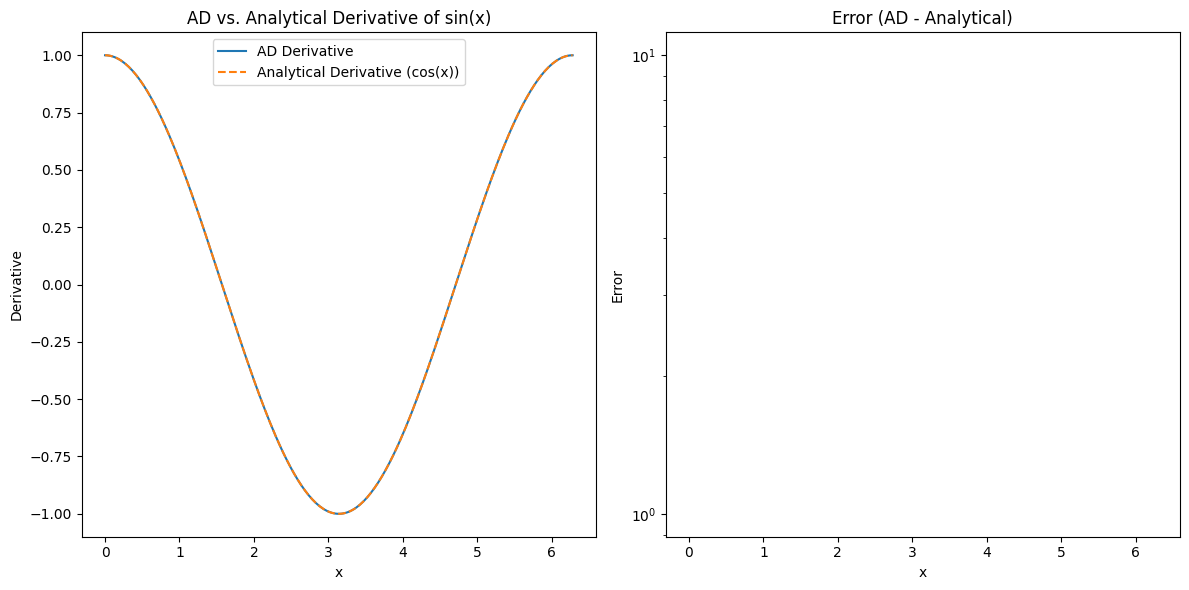

C:\Users\Captain\AppData\Local\Temp\ipykernel_21676\1497486147.py:41: RuntimeWarning: divide by zero encountered in log10
  magnitude = np.floor(np.log10(error_magnitude))


-inf

In [5]:
x = torch.linspace(0, 2*np.pi, 256, requires_grad=True)
y = torch.sin(x)

# compute gradient
for value in x:
    torch.sin(value).backward()
# extract gradient
grad_AD = x.grad

# Analytical deriv of sin is cos
grad_analytical = torch.cos(x)

# Compare AD deriv with analytical deriv
error = torch.abs(grad_AD - grad_analytical)

# Plotting the AD derivative and the analytical derivative
plt.figure(figsize=(12, 6))

# Plot AD derivative
plt.subplot(1, 2, 1)
plt.plot(x.detach(), grad_AD.detach(), label='AD Derivative')
plt.plot(x.detach(), grad_analytical.detach(), label='Analytical Derivative (cos(x))', linestyle="--")
plt.xlabel('x')
plt.ylabel('Derivative')
plt.title('AD vs. Analytical Derivative of sin(x)')
plt.legend()

# Plot error
plt.subplot(1, 2, 2)
plt.plot(x.detach(), error.detach())
plt.xlabel('x')
plt.ylabel('Error')
plt.title('Error (AD - Analytical)')
plt.yscale('log')  # Log scale for error to check the order of magnitude

plt.tight_layout()
plt.show()

# Computing the order of magnitude of the error
error_magnitude = torch.max(error).item()
magnitude = np.floor(np.log10(error_magnitude))
magnitude

<div style="background-color: #2a2c2b; color: white; padding: 10px; font-size: 14px;">

Plotting both the AD and analytical gradients we can't see any apparent discrepency between them. The plot on the right gives the error as x goes from 0 to 2 pi but the plot appears empty. Finally, checking the magnitude of the error we get a runtime warning as the error is too close to zero resulting in its order of magnitude being negative infinity. 

I'll proceed to try the same using double precision. 
    
</div>

C:\Users\Captain\AppData\Local\Temp\ipykernel_21676\2722606833.py:34: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')  # Log scale for error to check the order of magnitude


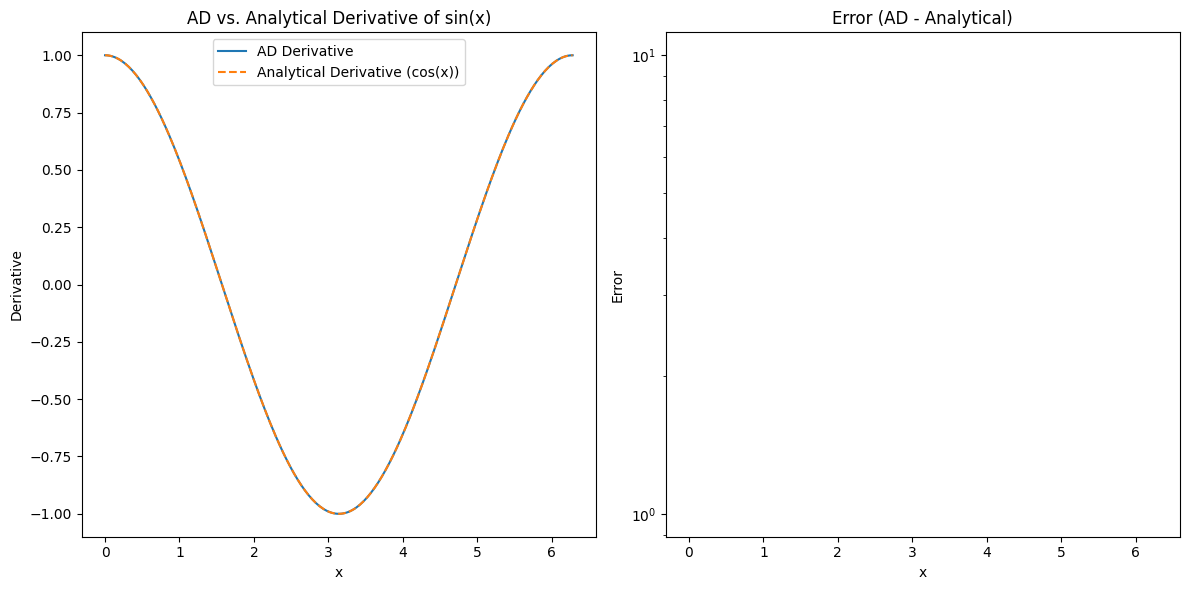

C:\Users\Captain\AppData\Local\Temp\ipykernel_21676\2722606833.py:41: RuntimeWarning: divide by zero encountered in log10
  magnitude = np.floor(np.log10(error_magnitude))


-inf

In [6]:
x = torch.linspace(0, 2*np.pi, 256, dtype=torch.float64, requires_grad=True)
y = torch.sin(x)

# compute gradient
for value in x:
    torch.sin(value).backward()
# extract gradient
grad_AD = x.grad

# Analytical deriv of sin is cos
grad_analytical = torch.cos(x)

# Compare AD deriv with analytical deriv
error = torch.abs(grad_AD - grad_analytical)

# Plotting the AD derivative and the analytical derivative
plt.figure(figsize=(12, 6))

# Plot AD derivative
plt.subplot(1, 2, 1)
plt.plot(x.detach(), grad_AD.detach(), label='AD Derivative')
plt.plot(x.detach(), grad_analytical.detach(), label='Analytical Derivative (cos(x))', linestyle='--')
plt.xlabel('x')
plt.ylabel('Derivative')
plt.title('AD vs. Analytical Derivative of sin(x)')
plt.legend()

# Plot error
plt.subplot(1, 2, 2)
plt.plot(x.detach(), error.detach())
plt.xlabel('x')
plt.ylabel('Error')
plt.title('Error (AD - Analytical)')
plt.yscale('log')  # Log scale for error to check the order of magnitude

plt.tight_layout()
plt.show()

# Computing the order of magnitude of the error
error_magnitude = torch.max(error).item()
magnitude = np.floor(np.log10(error_magnitude))
magnitude

<div style="background-color: #2a2c2b; color: white; padding: 10px; font-size: 14px;">

Even at double precision the AD grad is indeistinguishable from the analytical gradient. PyTorch has predefined derivatives for a wide range of standard functions including sin, the error appears to be zero in this case because it is in fact zero. Torch is not using an approximation scheme to get the derivative it is directly applying the known analytical solution.
    
</div>

2. In the previous gradient descent exercise, you implemented had to explicitly implement the analytical gradient of the function f(x,y). Now that you know about AD, implement a new routine called "AD_grad_f(x,y)" that uses AD to compute the gradient. Repeat the gradient descent problem of the previous exercise with the new "AD_grad_f(x,y)" routine to make sure everything is working properly.

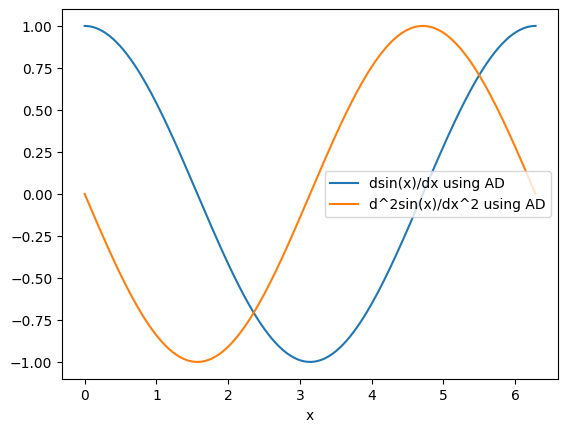

In [10]:
###############################################################
#### Helpful routine for exercise 2 (and later exercises)  ####
###############################################################

# The .backward() operation needs to be done on scalars, but we can take advantage of torch.autograd.grad to do autodifferentiation over a tensor.
# Here is a useful routine to compute the nth derivative of an tensor:

def nth_derivative(f, wrt, n):
    """
    f is a torch.tensor
    wrt is another torch.tensor and represents the variable we want to differentiate f 'with respect to'
    n is the order of the derivative.
    """
    for i in range(n):
        grads = torch.autograd.grad(f, wrt, create_graph=True, allow_unused=True, grad_outputs = torch.ones_like(f))[0]
        f = grads
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads

# Here is how to use it:
x = torch.linspace(0,2*np.pi,256, dtype = torch.float32).requires_grad_(True)
sin = torch.sin(x)

plt.plot(x.detach().numpy(), nth_derivative(sin, x, n=1).detach().numpy(), label = 'dsin(x)/dx using AD') 
plt.plot(x.detach().numpy(), nth_derivative(sin, x, n=2).detach().numpy(), label = 'd^2sin(x)/dx^2 using AD') 
plt.xlabel('x')
plt.legend()

<div style="background-color: #2a2c2b; color: white; padding: 10px; font-size: 14px;">

We'll now repeat the previous exercise using AD instead of manually defining the gradient.
    
</div>

In [13]:
def f_torch(x, y):
    return 3 * (x - 1)**2 + (y - 2)**2

def AD_grad_f(x, y):
    x_torch = torch.tensor([x], requires_grad=True, dtype=torch.float32)
    y_torch = torch.tensor([y], requires_grad=True, dtype=torch.float32)

    z = f_torch(x_torch, y_torch)

    # Backward pass to compute the gradient
    z.backward()

    #Extract the gradients
    grad_x = x_torch.grad.item() #Grab grad x element from grad
    grad_y = y_torch.grad.item()

    return np.array([grad_x, grad_y])

def gradient_descent_step_AD(x, y):
    grad = AD_grad_f(x, y)

    #Update
    x = x - lr*grad[0]
    y = y - lr*grad[1]

    return np.array([x, y])

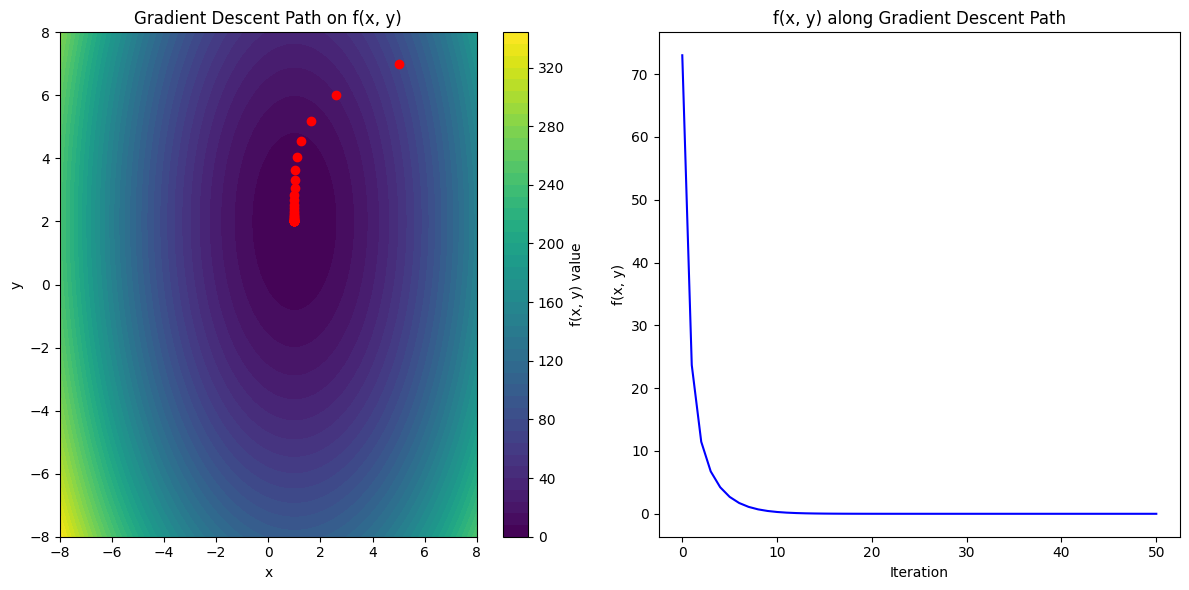

Last few steps in x_path: [1.0000000238418578, 1.0000000238418578, 1.0000000238418578, 1.0000000238418578, 1.0000000238418578]
Last few steps in y_path: [2.0001742362976063, 2.000139379501342, 2.000111484527587, 2.000089168548583, 2.000071334838866]


In [14]:
# Initial guess, learning rate, and steps as before
guess = (5, 7)
lr = 0.1
steps = 50

# Arrays to trace/store grad descent steps, reinitialized
x_path, y_path, f_path = [guess[0]], [guess[1]], [f(guess[0], guess[1])]

# Loop gradient step (gradient descent) with AD
x, y = guess
for _ in range(steps):
    x, y = gradient_descent_step_AD(x, y)
    x_path.append(x)
    y_path.append(y)
    f_path.append(f(x, y))

# 2D grid of X and Y values
X = np.linspace(-8,8,128)
Y = np.linspace(-8,8,128)
X, Y = np.meshgrid(X,Y)
Z = f(X, Y)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Color plot of f(x, y)
cp = axes[0].contourf(X, Y, Z, levels=50, cmap='viridis')
axes[0].scatter(x_path, y_path, color='red')  # Gradient descent path
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Gradient Descent Path on f(x, y)')

# Line plot of f(x, y) along the gradient descent path
axes[1].plot(f_path, color='blue')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('f(x, y)')
axes[1].set_title('f(x, y) along Gradient Descent Path')

plt.colorbar(cp, ax=axes[0], label='f(x, y) value')
plt.tight_layout()
plt.show()

# Print the last few steps to check for convergence
print("Last few steps in x_path:", x_path[-5:])
print("Last few steps in y_path:", y_path[-5:])

### 1.2. Gradient descent using automatic differentiation to compute gradients

Now that you have implemented your own gradient descent algorithm and understand how it works, study the example below to learn how to use PyTorch's own optimization package (which includes gradient descent as well as other more sophisticated algorithms) to find the minimum of f(x,y). Make sure you understand each step. Learning how to use this will be useful for later exercises.

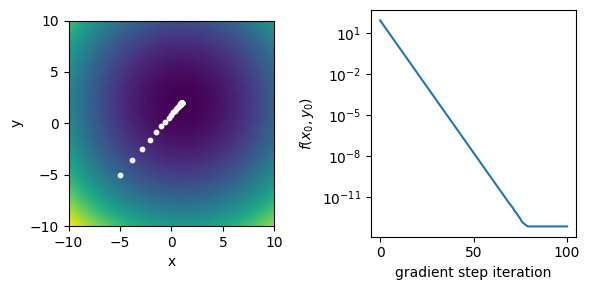

In [16]:
def f(x,y):
    return (x-1)**2 + (y-2)**2

# Initializing x0 and y0 as torch tensors
x0 = -5*torch.ones((1,), dtype = torch.float32)
y0 = -5*torch.ones((1,), dtype = torch.float32)

# We will want to compute gradients with respect to these variables so we need to set .requires_grad_(True)
x0.requires_grad_(True)
y0.requires_grad_(True)

# Here you will define an optimizer object.
# torch.optim contains various optimization algorithms. Here you will use SGD (stochastic gradient descent).
# This is done by the following line of code
optimizer = torch.optim.SGD([x0,y0], lr=0.1) 
# the arguments [x0,y0] are the parameters we want to optimize, and lr is the learning rate parameter.
# You will see how to use this optimizer to perform gradient descent steps below.

# Defininig empty lists to track the history/trajectory of the parameters x and y and the value of f(x,y).
# This is for diagnostic purposes.
x_history = []
y_history = []
f_history = []


''' Before appending the values x0, y0, and f(x0,y0), you have to remember that these are torch.tensor objects.
And since you have requested that gradients may be computed with respect to these variables, you first have to 
.detach() these variables from the computational graph, and then convert it to a numpy array.'''
x_history.append(x0.detach().numpy()[0])
y_history.append(y0.detach().numpy()[0])
f_history.append(f(x0,y0).detach().numpy())

for i in range(100):
    
    optimizer.zero_grad() # set all gradients to zero (otherwise the gradient values accumulate every time the .backward() operation is called)
    f(x0,y0).backward() # execute the .backward() operation (which computes AD with respect to )
    optimizer.step() # perform one optimization step (one gradient descent step)
    
    x_history.append(x0.detach().numpy()[0])
    y_history.append(y0.detach().numpy()[0])
    f_history.append(f(x0,y0).detach().numpy())

    
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
X = np.linspace(-10,10,128)
Y = np.linspace(-10,10,128)
X, Y = np.meshgrid(X,Y)
plt.imshow(f(X,Y), origin='lower', extent = [X.min(),X.max(),Y.min(),Y.max()])
plt.scatter(x_history,y_history, s = 10, c='w')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1,2,2)
plt.semilogy(f_history)
plt.xlabel('gradient step iteration')
plt.ylabel('$f(x_0,y_0)$')

plt.tight_layout()

## Solving simple ODE as optimization problem

We're now going to apply the methods above to solve the simple ODE problem we discussed in class:

$\frac{d}{dx}f(x) = f(x)$, with $f(0) = 1$.

We're interested in solving this ODE in the interval $x \in [0,1]$.

1) As we did in class, we're going to first define a trial function for $f(x)$. We will use a polynomial representation for $f(x)$. Implement a trial function that takes in the array $x$ and a vector $\theta = [\theta_0, \theta_1, ..., \theta_{n-1}]$, and outputs $1 + \sum_{i=0}^{n-1} \theta_i x^{i+1}$. Note that if $n = 2$, then we have the trial function we used in class: $f(x;\theta) = 1+ \theta_0 x+ \theta_1 x^2$.

In [17]:
def trial_f(x, theta):
    n = len(theta)
    f_x = 1 + sum(theta[i]*x**(i+1) for i in range(n))
    return f_x

2) Now we need to define the discrepancy error ($L_{ODE}$) function that measures how well the trail function satisfied the ODE. Implement this function and call it L_ODE. It should take in the array $x$ and the vector $\theta$. There is already a routine available for you below called nth_derivative, which allows you to compute derivatives of your trial function with respect to $x$ up to arbitrary derivative order $n$. You will need to call this routine inside L_ODE.

In [18]:
def trial_f(x, theta):
    n = len(theta)
    f_x = 1 + sum(theta[i]*x**(i+1) for i in range(n))
    return f_x

def nth_derivative(f, wrt, n):
    """
    f is a torch.tensor
    wrt is another torch.tensor and represents the variable we want to differentiate f 'with respect to'
    n is the order of the derivative.
    """
    for i in range(n):
        grads = torch.autograd.grad(f, wrt, create_graph=True, allow_unused=True, grad_outputs = torch.ones_like(f))[0]
        f = grads
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads

def L_ODE(x, theta):
    #compute the trial function
    f_x = trial_f(x, theta)
    
    #compute deriv
    df_dx = nth_derivative(f_x, x, n=1)

    #compute mean squared error between dfdx and f_x
    err = torch.mean((df_dx - f_x)**2)
    return err

3) We're now almost ready to solve the ODE as an optimization problem. First, define torch tensors for $x$ (with linearly spaced values between 0 and 1; you can discretize it with $128$ points) and $\theta$; you can choose a random initialization for $\theta$, for instance $\theta = [\theta_0, \theta_1] = [2.,3.]$. Create an optimizer object using torch.optim.SGD where you supply the parameters $\theta$, which we want optimize. Then create a loop where you compute the quantity you want to minimize ($L_{ODE}$), compute derivatives using AD with respect to inputs using the .backward() iteration, and do an optimization step. Keep track of the value of $L_{ODE}$ to make sure it's converging. Once you've found the optimal $\theta$, plot the optimal trial function and overlay it with the analytical solution $exp(t)$. Compute the absolute difference between the optimal trial function and the analytical solution.

tensor([2., 3.], requires_grad=True)
Iteration 0: Loss = 4.120490550994873
Iteration 100: Loss = 0.004164625890552998
Iteration 200: Loss = 0.004150684457272291
Iteration 300: Loss = 0.004150671884417534
Iteration 400: Loss = 0.004150670021772385
Iteration 500: Loss = 0.004150670021772385
Iteration 600: Loss = 0.004150670021772385
Iteration 700: Loss = 0.004150670021772385
Iteration 800: Loss = 0.004150670021772385
Iteration 900: Loss = 0.004150670021772385


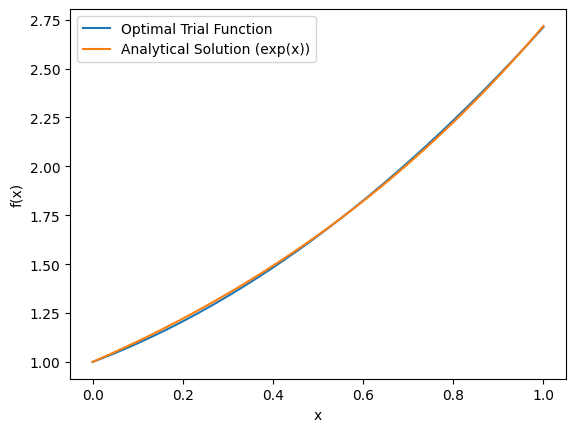

Maximum absolute difference of optimal solution found with 2 theta parameters: 0.01419


In [23]:
#Define tensors
x = torch.linspace(0, 1, 128, requires_grad=True)
theta = torch.tensor([2., 3.], requires_grad=True)


#Create optimizer
optimizer = torch.optim.SGD([theta], lr=0.1)

#Optimization loop
for iteration in range(1000):
    optimizer.zero_grad() #clear previous gradient each iteration
    loss = L_ODE(x, theta) #compute loss
    loss.backward() #compute gradient
    optimizer.step() #step using optimizer (update theta)

    if iteration % 100 == 0: #check progress every 100 steps
        print(f"Iteration {iteration}: Loss = {loss}")

#Compute the optimal trial function and analytical solution 
optimal_solution = trial_f(x.detach(), theta.detach()).detach().numpy()
analytical_solution = np.exp(x.detach()).detach().numpy()

#Plotting
plt.plot(x.detach().numpy(), optimal_solution, label="Optimal Trial Function")
plt.plot(x.detach().numpy(), analytical_solution, label="Analytical Solution (exp(x))")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

#Compute the absolute difference
absolute_difference_2p = np.abs(optimal_solution - analytical_solution)
max_diff_2p = np.max(absolute_difference_2p)
print(f"Maximum absolute difference of optimal solution found with 2 theta parameters: {max_diff_2p:.5f}")

4) Repeat this exercise for a trial function using 4 parameters $\theta = [\theta_0, \theta_1, \theta_2, \theta_3]$. This corresponds to a 4th order polynomial trial function. What is the optimal $\theta$? Verify that such a trial function gives a better approximation to the true solution.

Iteration 0: Loss = 131.40151977539062
Iteration 100: Loss = 0.001036942470818758
Iteration 200: Loss = 0.00020227213099133223
Iteration 300: Loss = 3.9658778405282646e-05
Iteration 400: Loss = 7.974222171469592e-06
Iteration 500: Loss = 1.7958918760996312e-06
Iteration 600: Loss = 5.870979862265813e-07
Iteration 700: Loss = 3.466230396043102e-07
Iteration 800: Loss = 2.948839323835273e-07
Iteration 900: Loss = 2.801503455884813e-07


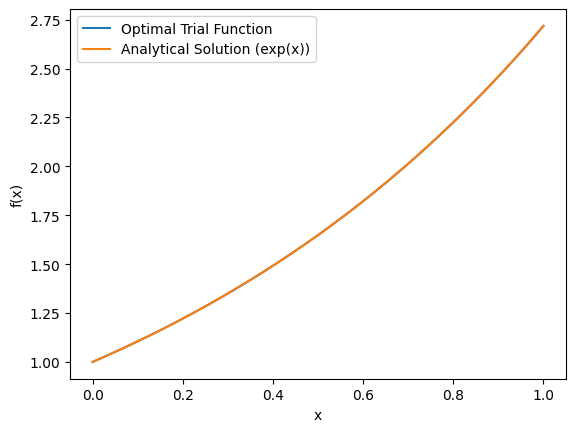

Maximum absolute difference of optimal solution found with 4 theta parameters: 0.00008
The polynomial of degree 4 has the smaller maximum absolute difference: 7.92e-05


In [21]:
#Define tensors
x = torch.linspace(0, 1, 128, requires_grad=True)
theta = torch.tensor([2., 3., 4., 5.], requires_grad=True)

#Create optimizer
optimizer = torch.optim.SGD([theta], lr=0.1)

#Optimization loop
for iteration in range(1000):
    optimizer.zero_grad() #clear previous gradient each iteration
    loss = L_ODE(x, theta) #compute loss
    loss.backward() #compute gradient
    optimizer.step() #step using optimizer (update theta)

    if iteration % 100 == 0: #check progress every 100 steps
        print(f"Iteration {iteration}: Loss = {loss}")

#Compute the optimal trial function and analytical solution 
optimal_solution = trial_f(x.detach(), theta.detach()).detach().numpy()
analytical_solution = np.exp(x.detach()).detach().numpy()

#Plotting
plt.plot(x.detach().numpy(), optimal_solution, label="Optimal Trial Function")
plt.plot(x.detach().numpy(), analytical_solution, label="Analytical Solution (exp(x))")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

#Compute the absolute difference
absolute_difference_4p = np.abs(optimal_solution - analytical_solution)
max_diff_4p = np.max(absolute_difference_4p)
print(f"Maximum absolute difference of optimal solution found with 4 theta parameters: {max_diff_4p:.5f}")

#Verify that using 4 theta parameters results in a better fitting solution
if max_diff_2p < max_diff_4p:
    print(f"The polynomial of degree 2 has the smaller maximum absolute difference: {max_diff_2p:.3g}")
else:
    print(f"The polynomial of degree 4 has the smaller maximum absolute difference: {max_diff_4p:.3g}")

In [22]:
print(f"The found values of theta are, {theta.detach().numpy()}")

The found values of theta are, [1.0003135  0.502528   0.1506829  0.06477232]


<div style="background-color: #2a2c2b; color: white; padding: 10px; font-size: 14px;">

In conclusion we see that the optimizer has found a good fit to the equation on this interval. The fit is improved by adding more parameters which can be tweaked to obtain fit. Additional values of theta correspond to higher order terms in the polynomial expansion and by fine tuning on increasingly high order terms we can obtain a trial function which approximates the true analytical solution to arbitrary accuracy.

The found values of theta are close to their expected values, [1, 1/2, 1/6, 1/24] though higher order terms were not approximated as accurately as lower order terms. This makes sense, the lower order terms dominate the behaviour and the optimizer gets diminishing returns on minimizing the loss with progressively higher order terms. 
    
</div>